In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [2]:
TOTAL_SUPPLY = 120_000_000
MIN_STAKED = 1
CURRENT_STAKED = 29_613_203
MEV_PER_YEAR = 300_000

STAKED = np.linspace(MIN_STAKED, TOTAL_SUPPLY, 1000)

In [3]:
def calculate_real_issuance_yield(nominal_issuance_yield: np.ndarray) -> np.ndarray:
    return nominal_issuance_yield * (TOTAL_SUPPLY - STAKED) / (TOTAL_SUPPLY + nominal_issuance_yield * STAKED)

In [4]:
def calculate_real_eth_yield(nominal_issuance_yield: np.ndarray) -> np.ndarray:
    return - nominal_issuance_yield * STAKED / (TOTAL_SUPPLY + nominal_issuance_yield * STAKED)

In [5]:
def calculate_mev_yield(MEV_PER_YEAR: int) -> np.ndarray:
    return MEV_PER_YEAR / STAKED

In [6]:
def calculate_real_staking_yield(real_issuance_yield: np.ndarray, real_MEV_yield: np.ndarray) -> np.ndarray:
    return real_issuance_yield + real_MEV_yield

In [13]:
# Different nominal issuance curves
curve_current = 2.6 * 64 / np.sqrt(STAKED)
curve_halving_F = 2.6 * 32 / np.sqrt(STAKED)
curve_anders = 2.6 * 64 / (np.sqrt(STAKED)*(1+2**(-25)*STAKED))
curve_targeting = 2.6 * 64 * (1 / np.sqrt(STAKED) - 0.5 / np.where(STAKED < 60_000_000, np.sqrt(60_000_000 - STAKED), np.nan))

/var/folders/_z/lf74qlpx3tncnkbfs9301b2m0000gn/T/ipykernel_49290/2403442856.py:5: RuntimeWarning: invalid value encountered in sqrt
  curve_targeting = 2.6 * 64 * (1 / np.sqrt(STAKED) - 0.5 / np.where(STAKED < 60_000_000, np.sqrt(60_000_000 - STAKED), np.nan))


In [14]:
def produce_yield_data(curve):

    nominal_issuance_yield = curve
    mev_yield = calculate_mev_yield(MEV_PER_YEAR)
    nominal_staking_yield = nominal_issuance_yield + mev_yield

    real_issuance_yield = calculate_real_issuance_yield(nominal_issuance_yield)
    real_staking_yield = real_issuance_yield + mev_yield
    real_eth_yield = calculate_real_eth_yield(nominal_issuance_yield)

    net_incentive_staking = real_staking_yield - real_eth_yield
    share_realyield_of_stakingincentive = real_staking_yield / net_incentive_staking

    # A red for ETH yields, not too dark but still bright
    red_tone = '#C44536'
    # Green tone for issuance and staking yields
    green_tone_dark = '#3F7D20'  # A darker green tone

    yield_data_nominal = {
        'Nominal Total Staking Yield': {'values': nominal_staking_yield, 'x_values': STAKED, 'label': 'Nominal Total Staking Yield', 'color': green_tone_dark, 'linestyle': '--','latex_label':'y'},
        'Nominal Issuance Yield': {'values': nominal_issuance_yield, 'x_values': STAKED, 'label': 'Nominal Issuance Yield', 'color': green_tone_dark, 'linestyle': '-', 'latex_label':'y_i'},
        'Nominal ETH Yield': {'values': [0 for item in STAKED], 'x_values': STAKED, 'label': 'Nominal ETH yield', 'color': red_tone, 'linestyle': '-', 'lw': 2, 'latex_label':'\\eta'},
        }

    yield_data_real = {
        'Real Total Staking Yield': {'values': real_staking_yield, 'x_values': STAKED, 'label': 'Real Total Staking Yield', 'color': green_tone_dark, 'linestyle': '--', 'latex_label':'\overbar{y}'},
        'Real Issuance Yield': {'values': real_issuance_yield, 'x_values': STAKED, 'label': 'Real Issuance Yield', 'color': green_tone_dark, 'linestyle': '-', 'latex_label':'\overbar{y}_i'},
        'Real ETH Yield': {'values': real_eth_yield, 'x_values': STAKED, 'label': 'Real ETH Yield', 'color': red_tone, 'linestyle': '-', 'latex_label':'\overbar{\eta}'},
        }
    
    return yield_data_nominal, yield_data_real, net_incentive_staking, share_realyield_of_stakingincentive

In [15]:
def produce_yield_data_with_nominal(curve):
    # Assuming produce_yield_data(curve) now returns three values
    yield_data_nominal = produce_yield_data(curve)[0]
    yield_data_real = produce_yield_data(curve)[1]

    # Proceed with your logic to include the nominal total issuance yield
    nominal_curve_data = yield_data_nominal['Nominal Total Staking Yield'].copy()  # Copy to prevent modifying the original
    nominal_curve_data['color'] = '#CCCCCC'  # Faint grey color
    nominal_curve_data['label'] = 'Nominal Total Staking Yield'
    nominal_curve_data['linestyle'] = '-'
    nominal_curve_data['lw'] = 1

    # Add the nominal curve to the real yield data
    yield_data_real_with_nominal = yield_data_real.copy()
    yield_data_real_with_nominal['Nominal Total Issuance Yield'] = nominal_curve_data

    return yield_data_nominal, yield_data_real, yield_data_real_with_nominal


In [16]:
from matplotlib.patches import Patch

def plot_yields(yield_data: dict, filename: str) -> None:
    """
    Plots various yield curves based on the input dictionary, with aesthetics adjustments for clarity and visual appeal.
    
    Parameters:
    yield_data: Dictionary containing the yield data and their configurations.
    """
    plt.figure(figsize=(10, 6))
    ax = plt.gca()  # Get current axis for more detailed customization
    
    # Initialize variables to store y-values for the arrows
    real_eth_yield_y = None
    real_staking_yield_y = None

    for index, (name, data) in enumerate(yield_data.items()):
        ax.plot(data['x_values'], data['values'], label=data['label'], color=data.get('color'), linestyle=data.get('linestyle', '-'), linewidth=data.get('lw', 1.5))
        
        # Check if the curve is "Real ETH Yield"
        if 'Real ETH Yield' in name:
            # Fill area between x-axis and Real ETH Yield with transparent faint red
            ax.fill_between(data['x_values'], 0, data['values'], color='red', alpha=0.1)  # Adjust alpha for transparency
            # After filling the areas
            red_patch = Patch(color='red', alpha=0.1, label='Incentive to stake from real yield')
            green_patch = Patch(color='green', alpha=0.1, label='Incentive to stake from dilution protection')

            # When setting the legend, include the patches along with the other labels
            ax.legend(handles=[red_patch, green_patch] + ax.lines, frameon=False)
            
            if 'anders' in filename:
                x_coord = 23_000_000
            else: 
                x_coord = 80_000_000
            real_eth_yield_y = np.interp(x_coord, data['x_values'], data['values'])

        # Check if the curve is "Real Total Staking Yield"
        elif 'Real Total Staking Yield' in name:
            # Fill area between x-axis and Real Total Staking Yield with transparent faint green
            ax.fill_between(data['x_values'], 0, data['values'], color='green', alpha=0.1)  # Adjust alpha for transparency
            
            if 'anders' in filename:
                x_coord = 23_000_000
            else: 
                x_coord = 80_000_000
            real_staking_yield_y = np.interp(x_coord, data['x_values'], data['values'])
        
        # Check if we've plotted the first and second curves. If yes: color area inbetween and label as MEV yield. 
        if index == 1:  
            # Retrieve the values for the first curve
            first_curve_values = list(yield_data.values())[0]['values']
            # Retrieve the values for the second curve
            second_curve_values = data['values']
            # Arrow and label for MEV Yield
            x_position_for_arrow = 20_000_000  # Position for the arrow
            # Find the corresponding y values for the first and second curve at the x position
            y_value_first_curve = np.interp(x_position_for_arrow, data['x_values'], first_curve_values)
            y_value_second_curve = np.interp(x_position_for_arrow, data['x_values'], second_curve_values)
            # Draw the arrow
            ax.annotate('', xy=(x_position_for_arrow, y_value_first_curve), xytext=(x_position_for_arrow, y_value_second_curve),
                        arrowprops=dict(arrowstyle="<->", lw=1.5, color='black'))
            # Place the text label for the arrow
            # Offset the x position slightly to the left of the arrow's x position
            text_offset = 350_000  # Adjust the offset as needed
            mid_y_value = (y_value_first_curve + y_value_second_curve) / 2
            vertical_offset = 0.001
            ax.text(x_position_for_arrow - text_offset, mid_y_value + vertical_offset, 'MEV\nYield', 
                    color='black', fontsize=9, ha='right', va='center')

    # After the loop, check if both values have been set and then draw the arrow:
    if real_eth_yield_y is not None and real_staking_yield_y is not None:
        ax.annotate('', xy=(x_coord, real_eth_yield_y), xytext=(x_coord, real_staking_yield_y),
                    arrowprops=dict(arrowstyle="<->", lw=1.5, color='black'))
        ax.text(x_coord - 350_000, (real_eth_yield_y + real_staking_yield_y) / 2 - 0.003, 'Net incentive\nto stake',
                color='black', fontsize=9, ha='right', va='center')

    ax.set_xlabel('ETH Staked')
    ax.set_ylabel('Yield')
    legend = ax.legend(frameon=False, )  # Disable the legend frame for a cleaner look
    # Adjust the linewidth for each legend line, adhering to the updated attribute
    for legobj in legend.legend_handles:
        legobj.set_linewidth(1.5)
    
    ax.axhline(0, color='black', lw=0.5)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    
    ax.set_ylim(-0.03, 0.08)
    # # If nominal yields, don't show negative yield range
    # if filename=='nominal_yields':
    #     ax.set_ylim(0, 0.08)
    
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x / 1_000_000:.0f}M'))
    ax.set_xlim(0, 120_000_000)  # Adjust the x-axis range to 0 to 120M
    
    # Customizing the plot to remove top and right borders for an open look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Adjust the "Currently Staked" label for specified positioning and aesthetics
    current_staked_label = f'ETH Staked Today:  {CURRENT_STAKED / 1_000_000:.0f}M of 120M\n' + \
                           f'Staking Ratio:         {round(CURRENT_STAKED / TOTAL_SUPPLY,2)}'
    ax.axvline(CURRENT_STAKED, color='grey', lw=1, linestyle='--')
    ax.text(CURRENT_STAKED + 0.005 * (ax.get_xlim()[1] - ax.get_xlim()[0]), 0.075, current_staked_label, horizontalalignment='left', verticalalignment='center', color='grey', fontsize=9)
    
    # Set grid lines similar to the provided plot, with custom intervals and a light grey color 
    ax.xaxis.set_major_locator(plt.MultipleLocator(20_000_000))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='#dddddd')  # Light grey grid lines
    
    plt.tight_layout()  # Adjust layout to make sure everything fits without clipping
    plt.savefig(f'/Users/css/Desktop/{filename}.png', format='png', dpi=600)
    plt.show()

In [17]:
def plot_targeting_yields(yield_data, filename: str) -> None:
    """
    Plots various yield curves based on the input dictionary, with aesthetics adjustments for clarity and visual appeal.
    
    Parameters:
    yield_data: Dictionary containing the yield data and their configurations.
    """

    yield_data_nominal = yield_data[0]
    yield_data_real = yield_data[1]

    # Find the maximum x_value across all datasets to normalize the x-axis
    max_x_value = max(
        max(data['x_values']) for _, data in {**yield_data_nominal, **yield_data_real}.items()
    )

    plt.figure(figsize=(10, 6))
    ax = plt.gca()  # Get current axis for more detailed customization

    for index, (name, data) in enumerate(yield_data_real.items()):
        normalized_x_values = [x / max_x_value for x in data['x_values']]
        ax.plot(normalized_x_values, data['values'], label=data['label'], color=data.get('color'), linestyle=data.get('linestyle', '-'), linewidth=data.get('lw', 1.5))

    ax.set_xlabel('Staking Ratio')
    ax.set_ylabel('Yield')
    legend = ax.legend(frameon=False, )  # Disable the legend frame for a cleaner look
    
    ax.axhline(0, color='black', lw=0.5)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    
    ax.set_ylim(-0.03, 0.08)
    
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
    ax.set_xlim(0, 1)  # Adjust the x-axis range to 0 to 120M
    
    # Customizing the plot to remove top and right borders for an open look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set grid lines similar to the provided plot, with custom intervals and a light grey color 
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.2))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='#dddddd')  # Light grey grid lines

    # Adjust the "Currently Staked" label for specified positioning and aesthetics
    current_staked_label = f'ETH Staked Today:  {CURRENT_STAKED / 1_000_000:.0f}M of 120M\n' + \
                           f'Staking Ratio:         {round(CURRENT_STAKED / TOTAL_SUPPLY,2)}'
    ax.axvline(CURRENT_STAKED/max_x_value, color='grey', lw=1, linestyle='--')
    ax.text(CURRENT_STAKED/max_x_value + 0.005 * (ax.get_xlim()[1] - ax.get_xlim()[0]), 0.075, current_staked_label, horizontalalignment='left', verticalalignment='center', color='grey', fontsize=9)
    
    plt.tight_layout()  # Adjust layout to make sure everything fits without clipping
    plt.savefig(f'/Users/css/Desktop/{filename}.png', format='png', dpi=600)
    plt.show()

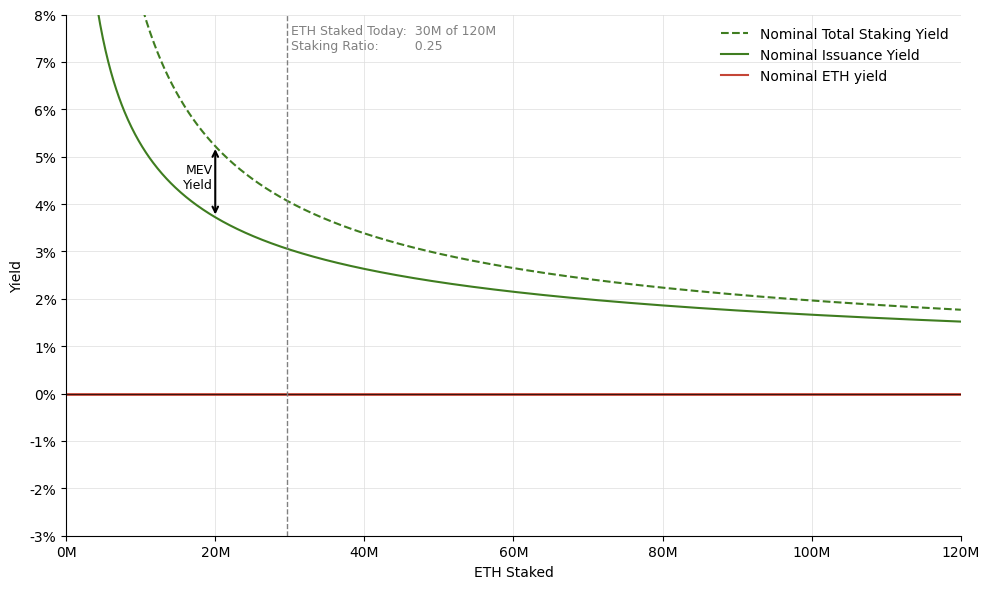

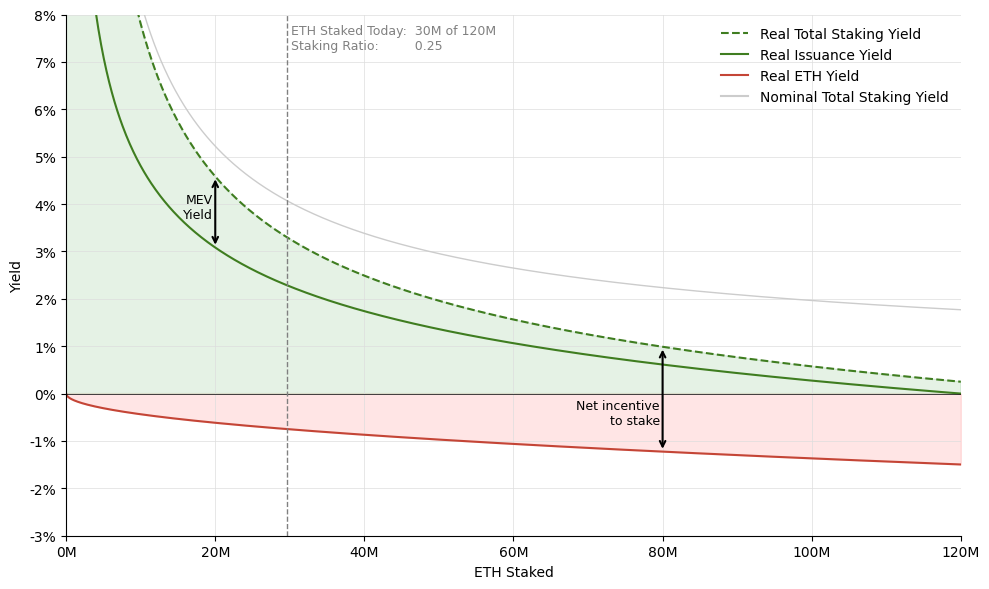

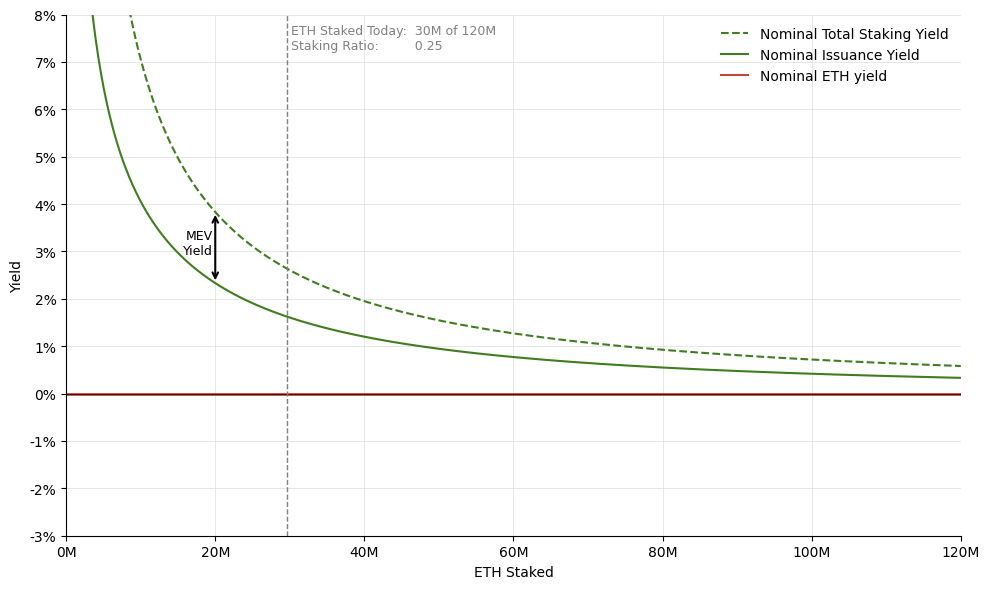

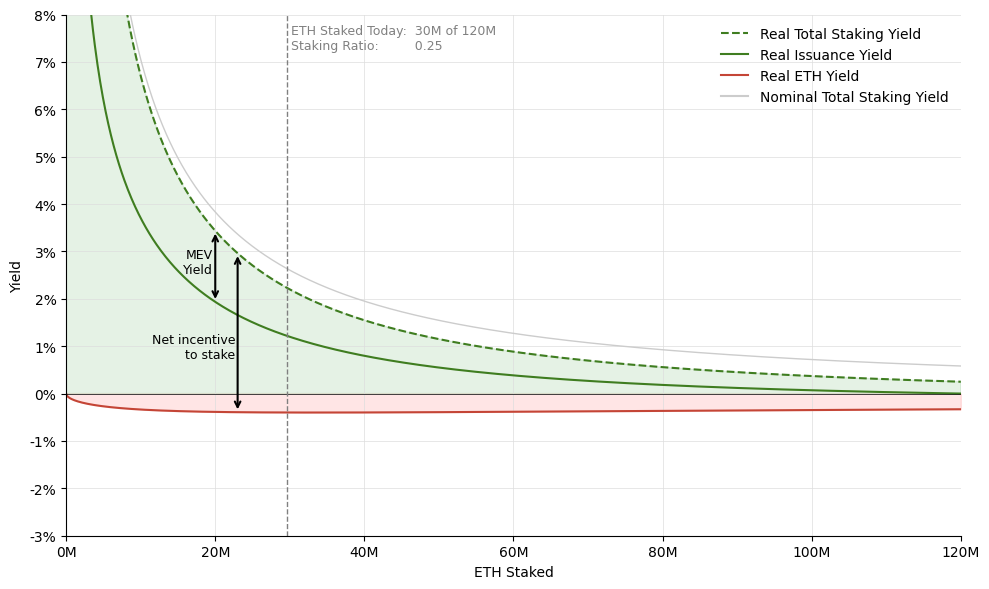

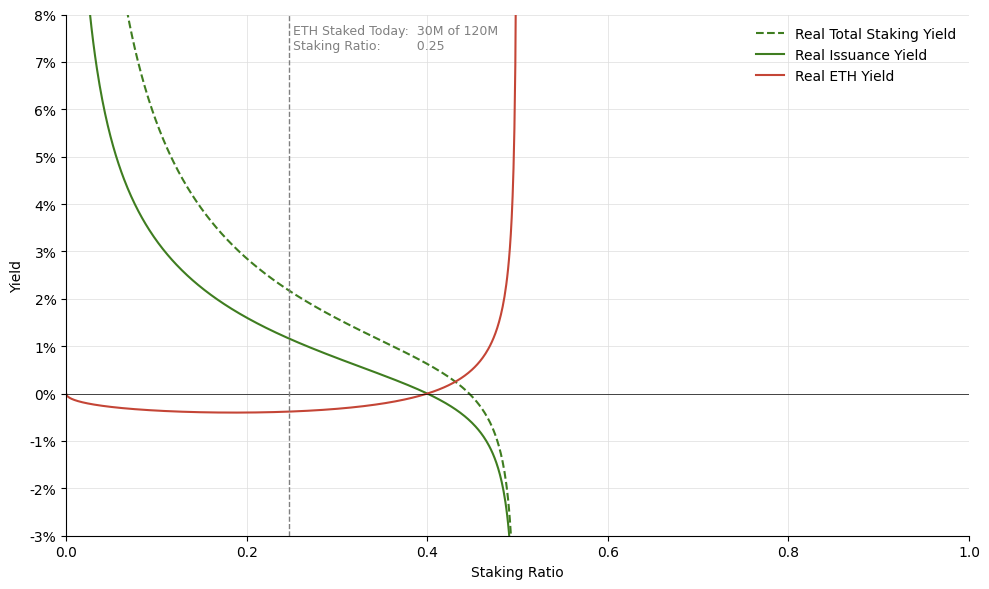

In [18]:
curves_info = {
    "current": {
        "curve": curve_current,
        "filename": "current"
    },
    "anders": {
        "curve": curve_anders,
        "filename": "anders"
    },
    "targeting": {
        "curve": curve_targeting,
        "filename": "targeting"
    }
}

for curve_key, curve_info in curves_info.items():
    curve = curve_info['curve']
    filename = curve_info['filename']
    # Assuming `curve` is defined and valid, generate the updated yield data
    yield_data_nominal, yield_data_real, yield_data_real_with_nominal = produce_yield_data_with_nominal(curve)
    
    if "targeting" in filename:
        yield_data = produce_yield_data(curve_targeting)
        plot_targeting_yields(yield_data, f"real_yields_{filename}")
        continue

    # Plot nominal yields only
    plot_yields(yield_data_nominal, f"nominal_yields_{filename}")
    # Plot real yields with the nominal total issuance yield included
    plot_yields(yield_data_real_with_nominal, f"real_yields_{filename}")